In [84]:
import pathlib
import glob
import os
import collections
import json
from omegaconf import OmegaConf

import pickle
import sys
import glob
from pathlib import Path, PurePath
path = Path.cwd()
parent_path = path.parents[1]
sys.path.append(str(PurePath(parent_path, 'neuroformer')))
sys.path.append('neuroformer')
sys.path.append('.')
sys.path.append('../')

import pandas as pd
import numpy as np
from einops import rearrange

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data.dataloader import DataLoader

import math
from torch.utils.data import Dataset

from neuroformer.model_neuroformer import GPT, GPTConfig, neuralGPTConfig
from neuroformer.trainer import Trainer, TrainerConfig
from neuroformer.utils import set_seed, update_object, check_common_attrs
from neuroformer.visualize import set_plot_params
from neuroformer.SpikeVidUtils import round_n, set_intervals
set_plot_params()

from scipy import io as scipyio
from scipy.special import softmax
import skimage
import skvideo.io
from scipy.ndimage import gaussian_filter, uniform_filter

parent_path = os.path.dirname(os.path.dirname(os.getcwd())) + "/"
import argparse


In [85]:
def align_trials(df_glm, t_data, key='raw_interval'):
    for i, trial in enumerate(t_data['Trial'].unique()):
        start_interval = t_data[t_data['Trial'] == trial][key].min()
        end_interval = t_data[t_data['Trial'] == trial][key].max()
        # print(start_interval, end_interval, trial)
        df_glm.loc[(df_glm[key] >= start_interval) & (df_glm[key] <= end_interval), 'Trial'] = trial
    return df_glm

In [86]:
from neuroformer.SpikeVidUtils import create_full_trial
from neuroformer.SpikeVidUtils import make_intervals
from neuroformer.analysis import get_rates_trial, calc_corr_psth, get_accuracy, compute_scores

DATASET = "V1_AL"
T_BIN = 1

In [87]:
data_path = "./data/Combo3_V1AL/Combo3_V1AL_response.csv"
df = pd.read_csv(data_path)
df['Interval'] = make_intervals(df, T_BIN)

pred_path = "./data/Combo3_V1AL/glm_comparison/pred.csv"
df_pred = pd.read_csv(pred_path)

In [88]:
glm_path = "./data/Combo3_V1AL/combo3neuronGLM.mat"
mat = scipyio.loadmat(glm_path)
df_glm = pd.DataFrame(mat['glmneuron'], columns=['Interval', 'ID', 'Trial']).reset_index(drop=True)
df_glm['Time'] = df_glm['Interval']
df_glm = df_glm.sort_values(by=['Trial', 'Interval']).reset_index(drop=True)
df_glm = align_trials(df_glm, df_pred, key='Interval')
df_glm['Interval'] = make_intervals(df_glm, T_BIN)

In [89]:
# trial ranges trial 0-20:(0 - 32), trial 20-40 (32 - 64), trial 40-60:(64 - 96)

df['Interval'][df['Trial'] > 20] = df['Interval'][df['Trial'] > 20] + 32
df_pred['Interval'][df_pred['Trial'] > 20] = df_pred['Interval'][df_pred['Trial'] > 20] + 32
df_glm['Interval'][df_glm['Trial'] > 20] = df_glm['Interval'][df_glm['Trial'] > 20] + 32

df['Interval'][df['Trial'] > 40] = df['Interval'][df['Trial'] > 40] + 32
df_pred['Interval'][df_pred['Trial'] > 40] = df_pred['Interval'][df_pred['Trial'] > 40] + 32
df_glm['Interval'][df_glm['Trial'] > 40] = df_glm['Interval'][df_glm['Trial'] > 40] + 32



In [8]:
df_glm = df_glm.sort_values(by=['Trial', 'Interval']).reset_index(drop=True)    
print(df_glm['Trial'].unique())

[ 1.  6. 12. 18. 21. 26. 32. 38. 41. 46. 52. 58.]


In [9]:
trials = df_pred['Trial'].unique()
n_1 = trials + 1
n_2 = trials + 2

In [10]:
from neuroformer.SpikeVidUtils import create_full_trial

df_pred = create_full_trial(df_pred, trials)
df_1 = create_full_trial(df, trials)
df_2 = create_full_trial(df, n_1)
df_3 = create_full_trial(df, n_2)
df_glm = create_full_trial(df_glm, trials)

df_pred['Interval'] = make_intervals(df_pred, T_BIN)
df_1['Interval'] = make_intervals(df_1, T_BIN)
df_2['Interval'] = make_intervals(df_2, T_BIN)
df_3['Interval'] = make_intervals(df_3, T_BIN)

# trim everything to length L
# L = 100
# df_pred = df_pred.iloc[:L]
# df_1 = df_1.iloc[:L]
# df_2 = df_2.iloc[:L]
# df_3 = df_3.iloc[:L]

In [11]:
from neuroformer.analysis import compute_scores, compute_scores_scikit
scores = compute_scores(df_1, df_pred)
scores_scikit = compute_scores_scikit(df_1, df_pred)

scores_glm = compute_scores(df_1, df_glm)
scores_scikit_glm = compute_scores_scikit(df_1, df_glm)

print("Scores")
print("Neuroformer")
print(scores)
print("GLM")
print(scores_glm)

print("Scores Scikit")
print("Neuroformer")
print(scores_scikit)
print("GLM")
print(scores_scikit_glm)

Scores
Neuroformer
defaultdict(<class 'list'>, {'precision': 0.4879317234078607, 'recall': 0.4890535120165209, 'F1': 0.4811950894577328})
GLM
defaultdict(<class 'list'>, {'precision': 0.09260728408552006, 'recall': 0.2123286121192974, 'F1': 0.12368292339827582})
Scores Scikit
Neuroformer
defaultdict(<class 'list'>, {'precision': 0.32963466667126196, 'recall': 0.3185108052604686, 'F1': 0.3191539454174762})
GLM
defaultdict(<class 'list'>, {'precision': 0.10424031225966345, 'recall': 0.21413407873602805, 'F1': 0.12850604306613614})


In [12]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming your dataframes are named 'pred' and 'true'

# Define the number of bins
true = df_1
pred = df_pred

# Bin the 'Interval' values into classes
pred['Interval_pred'] = pd.Categorical(pred['Interval']).codes
true['Interval_true'] = pd.Categorical(true['Interval']).codes

# Merge your dataframes on 'ID' and 'Trial' to align predictions with ground truth
merged_df = pd.merge(pred, true, on=['ID', 'Trial'])

# Then group by 'ID' and 'Trial'
grouped = merged_df.groupby(['ID', 'Trial'])

# Initialize lists to store results
ids = []
trials = []
precisions = []
recalls = []
f1s = []

# For each group, calculate precision, recall, and F1 score
for name, group in grouped:
    id, trial = name
    precision = precision_score(group['Interval_true'], group['Interval_pred'], average='micro')
    recall = recall_score(group['Interval_true'], group['Interval_pred'], average='micro')
    f1 = f1_score(group['Interval_true'], group['Interval_pred'], average='micro')
    
    ids.append(id)
    trials.append(trial)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)

# Create a results DataFrame
results = pd.DataFrame({
    'ID': ids,
    'Trial': trials,
    'Precision': precisions,
    'Recall': recalls,
    'F1': f1s
})

mean_results = results.mean()

print(results.mean())


ID           264.497409
Trial          0.000000
Precision      0.048658
Recall         0.048658
F1             0.048658
dtype: float64


In [13]:
print(mean_results)

ID           264.497409
Trial          0.000000
Precision      0.048658
Recall         0.048658
F1             0.048658
dtype: float64


In [14]:
df_pred_full = df_pred

window = 0.5
window_prev = 0.5
window_pred = 0.5
labels = np.array([round(window_pred + window_pred*n, 2) for n in range(0, int(max(df_pred_full['Interval']) / window_pred))])

df_1 = set_intervals(df_1, window, window_prev, window_pred)
df_2 = set_intervals(df_2, window, window_prev, window_pred)
df_3 = set_intervals(df_3, window, window_prev, window_pred)

rates_pred = get_rates_trial(df_pred_full, labels)
rates_1 = get_rates_trial(df_1, labels)
rates_2 = get_rates_trial(df_2, labels)
rates_3 = get_rates_trial(df_3, labels)
rates_glm = get_rates_trial(df_glm, labels)

neurons = df['ID'].unique()
top_corr_pred = calc_corr_psth(rates_pred, rates_1, neurons=neurons)
top_corr_real = calc_corr_psth(rates_1, rates_2, neurons=neurons)
top_corr_real_2 = calc_corr_psth(rates_1, rates_3, neurons=neurons)
top_corr_glm = calc_corr_psth(rates_glm, rates_1, neurons=neurons)

# turn index into ID column
top_corr_pred = top_corr_pred.reset_index()
top_corr_real = top_corr_real.reset_index()
top_corr_glm = top_corr_glm.reset_index()

# rename columns
top_corr_pred = top_corr_pred.rename(columns={'index': 'ID', 0: 'Correlation'})
top_corr_real = top_corr_real.rename(columns={'index': 'ID', 0: 'Correlation'})
top_corr_glm = top_corr_glm.rename(columns={'index': 'ID', 0: 'Correlation'})

In [15]:
top_corr_pred

,ID,pearson_r
0,206,0.768396
1,252,0.714798
2,197,0.713732
3,285,0.703210
4,217,0.681284
...,...,...
381,125,-0.050360
382,493,-0.052192
383,294,-0.063615
384,470,-0.065110


In [16]:
# # turn index into ID column
# top_corr_pred = top_corr_pred.reset_index()
# top_corr_real = top_corr_real.reset_index()
# top_corr_glm = top_corr_glm.reset_index()

# # rename columns
# top_corr_pred = top_corr_pred.rename(columns={'index': 'ID', 0: 'Correlation'})
# top_corr_real = top_corr_real.rename(columns={'index': 'ID', 0: 'Correlation'})
# top_corr_glm = top_corr_glm.rename(columns={'index': 'ID', 0: 'Correlation'})

In [17]:
# find duplicate values in IDF

In [18]:
merged_df

,ID,dt,Trial,Interval_x,Time_x,Interval_pred,Unnamed: 0,Time_y,Interval_y,Interval_true
0,479,0.00,0,1.0,0.199951,0,48,0.590912,1.0,0
1,479,0.00,0,1.0,0.199951,0,123,1.997641,2.0,1
2,479,0.00,0,1.0,0.199951,0,318,9.543693,10.0,9
3,479,0.00,0,1.0,0.199951,0,479,16.096446,17.0,16
4,479,0.00,0,1.0,0.199951,0,506,16.545939,17.0,16
...,...,...,...,...,...,...,...,...,...,...
621224,435,0.05,0,83.0,82.393750,82,22812,50.296270,51.0,50
621225,435,0.05,0,83.0,82.393750,82,29075,38.334716,39.0,38
621226,435,0.05,0,83.0,82.393750,82,29278,43.765513,44.0,43
621227,435,0.05,0,83.0,82.393750,82,39152,92.608107,93.0,92


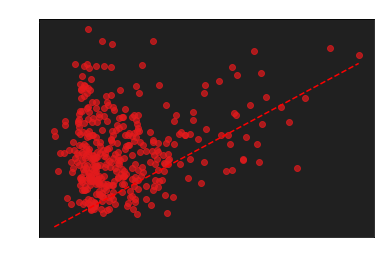

In [19]:
# Merge dataframes on 'ID'
merged_df = pd.merge(top_corr_pred, top_corr_glm, on=['ID'])

# Create a scatter plot
plt.scatter(merged_df['pearson_r_y'], merged_df['pearson_r_x'], alpha=0.7)

# Add a reference line (y=x) to show where the predicted correlation equals the true correlation
plt.plot(
    [merged_df['pearson_r_y'].min(), merged_df['pearson_r_y'].max()],
    [merged_df['pearson_r_y'].min(), merged_df['pearson_r_y'].max()],
    color='red', linestyle='--'
)

# Add axis labels and a title
plt.xlabel('True Correlation')
plt.ylabel('Predicted Correlation')
plt.title('Predicted vs. True Correlation')

# Show the plot
plt.show()

In [20]:
top_corr_pred

,ID,pearson_r
0,206,0.768396
1,252,0.714798
2,197,0.713732
3,285,0.703210
4,217,0.681284
...,...,...
381,125,-0.050360
382,493,-0.052192
383,294,-0.063615
384,470,-0.065110


In [21]:
top_ids = top_corr_pred.sort_values(by=['pearson_r'], ascending=False).iloc[:10]
print(top_ids)

    ID  pearson_r
0  206   0.768396
1  252   0.714798
2  197   0.713732
3  285   0.703210
4  217   0.681284
5  247   0.669083
6  142   0.651700
7  462   0.612992
8  484   0.608630
9  262   0.607740


In [25]:
# plot spikes for top 10 neurons
trial_duration = 96
n_intervals = int(trial_duration / window_pred)
intervals = np.array([round(window_pred + window_pred*n, 2) for n in range(0, n_intervals)])

print(intervals)

[ 0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.
  7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5 14.
 14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5 21.
 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5 28.
 28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5 35.
 35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.
 42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5 48.  48.5 49.
 49.5 50.  50.5 51.  51.5 52.  52.5 53.  53.5 54.  54.5 55.  55.5 56.
 56.5 57.  57.5 58.  58.5 59.  59.5 60.  60.5 61.  61.5 62.  62.5 63.
 63.5 64.  64.5 65.  65.5 66.  66.5 67.  67.5 68.  68.5 69.  69.5 70.
 70.5 71.  71.5 72.  72.5 73.  73.5 74.  74.5 75.  75.5 76.  76.5 77.
 77.5 78.  78.5 79.  79.5 80.  80.5 81.  81.5 82.  82.5 83.  83.5 84.
 84.5 85.  85.5 86.  86.5 87.  87.5 88.  88.5 89.  89.5 90.  90.5 91.
 91.5 92.  92.5 93.  93.5 94.  94.5 95.  95.5 96. ]


In [ ]:
glm_path = "./data/Combo3_V1AL/combo3neuronGLM.mat"
mat = scipyio.loadmat(glm_path)
df_glm = pd.DataFrame(mat['glmneuron'], columns=['Interval', 'ID', 'Trial']).reset_index(drop=True)
df_glm['Time'] = df_glm['Interval']
df_glm = df_glm.sort_values(by=['Trial', 'Interval']).reset_index(drop=True)
df_glm = align_trials(df_glm, df_pred, key='Interval')
df_glm['Interval'] = make_intervals(df_glm, T_BIN)

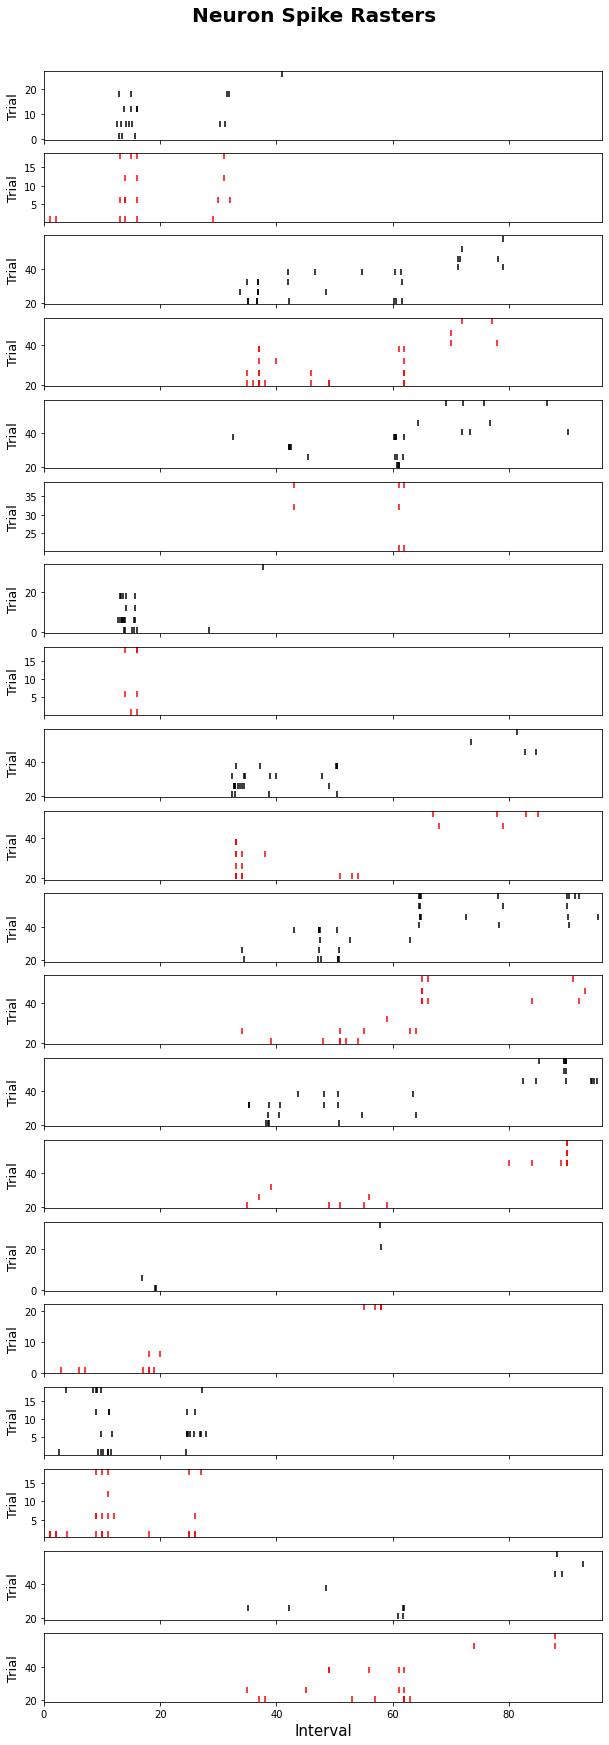

In [80]:
fig, axes = plt.subplots(20, 1, figsize=(10, 30), sharex=True)  # Create subplots with shared x-axis

for i in range(0, 10):
    neuron_id = top_ids.iloc[i]['ID']
    neuron_pred = df_pred[df_pred['ID'] == neuron_id]
    trials = neuron_pred['Trial'].unique()
    neuron_true = df[(df['ID'] == neuron_id) & (df['Trial'].isin(trials))]
    neuron_pred_times = neuron_pred['Time']
    neuron_true_times = neuron_true['Time']
    neuron_pred = neuron_pred.sort_values(by=['Time'])
    neuron_true = neuron_true.sort_values(by=['Time'])
    
    # Predicted plot on top
    axes[2*i].scatter(neuron_pred['Interval'], neuron_pred['Trial'], color='k', marker='|', label='Predicted')
    axes[2*i].set_xlim([0, 96])  # Setting x limits
    axes[2*i].set_ylabel('Trial', fontsize=13)
    
    # True plot at bottom
    axes[2*i+1].scatter(neuron_true['Interval'], neuron_true['Trial'], color='r', marker='|', label='True')
    axes[2*i+1].set_xlim([0, 96])  # Setting x limits
    axes[2*i+1].set_ylabel('Trial', fontsize=13)

plt.xlabel('Interval', fontsize=15)
plt.suptitle('Neuron Spike Rasters', fontsize=20, y=0.91)  # Main title for all subplots
plt.show()

In [95]:
df_glm

,Interval,ID,Trial,Time
0,1.0,16.0,1.0,0.066667
1,1.0,136.0,1.0,0.066667
2,1.0,306.0,1.0,0.066667
3,1.0,272.0,1.0,0.100000
4,1.0,416.0,1.0,0.100000
...,...,...,...,...
57915,96.0,510.0,58.0,31.983333
57916,96.0,193.0,58.0,32.000000
57917,96.0,361.0,58.0,32.000000
57918,96.0,469.0,58.0,32.000000


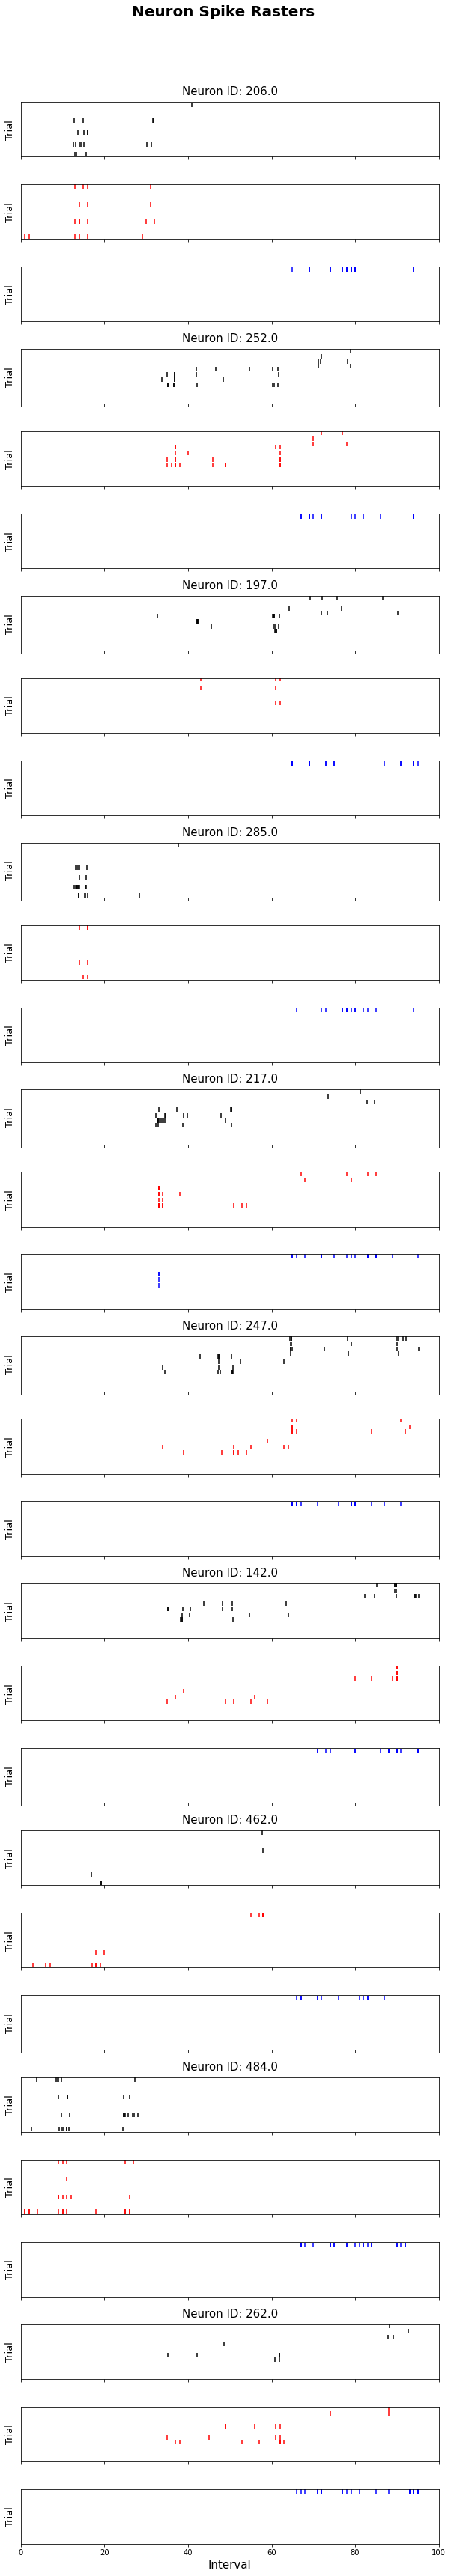

In [116]:
fig, axes = plt.subplots(30, 1, figsize=(10, 60), sharex=True)  # Create subplots with shared x-axis

for i in range(0, 10):
    neuron_id = top_ids.iloc[i]['ID']
    neuron_pred = df_pred[df_pred['ID'] == neuron_id]
    neuron_glm_pred = df_glm[df_glm['ID'] == neuron_id]
    trials = neuron_pred['Trial'].unique()
    neuron_true = df[(df['ID'] == neuron_id) & (df['Trial'].isin(trials))]
    neuron_pred_times = neuron_pred['Time']
    neuron_glm_pred_times = neuron_glm_pred['Time']
    neuron_true_times = neuron_true['Time']
    neuron_pred = neuron_pred.sort_values(by=['Time'])
    neuron_glm_pred = neuron_glm_pred.sort_values(by=['Time'])
    neuron_true = neuron_true.sort_values(by=['Time'])

    # Predicted plot on top
    axes[3*i].scatter(neuron_pred['Interval'], neuron_pred['Trial'], color='k', marker='|', label='Predicted')
    axes[3*i].set_xlim([0, 100])  # Setting x limits
    axes[3*i].set_ylabel('Trial', fontsize=13)
    axes[3*i].set_yticks([])  # Disable ytick labels
    axes[3*i].set_yticks(np.linspace(0, neuron_pred['Trial'].max(), 4))  # Keep 4 ticks on the y-axis

    # True plot at bottom
    axes[3*i+2].scatter(neuron_glm_pred['Interval'], neuron_glm_pred['Trial'], color='b', marker='|', label='GLM Predicted')
    axes[3*i+2].set_xlim([0, 100])  # Setting x limits
    axes[3*i+2].set_ylabel('Trial', fontsize=13)
    axes[3*i+2].set_yticks([])  # Disable ytick labels
    axes[3*i+2].set_yticks(np.linspace(0, neuron_glm_pred['Trial'].max(), 4))  # Keep 4 ticks on the y-axis

    # GLM Predicted plot in the middle
    axes[3*i+1].scatter(neuron_true['Interval'], neuron_true['Trial'], color='r', marker='|', label='True')
    axes[3*i+1].set_xlim([0, 100])  # Setting x limits
    axes[3*i+1].set_ylabel('Trial', fontsize=13)
    axes[3*i+1].set_yticks([])  # Disable ytick labels
    axes[3*i+1].set_yticks(np.linspace(0, neuron_true['Trial'].max(), 4))  # Keep 4 ticks on the y-axis

    # Add overarching title
    axes[3*i].set_title('Neuron ID: ' + str(neuron_id), fontsize=15, y=1.05)
    plt.subplots_adjust(hspace=0.5)


# disable all ytick labels
for ax in axes:
    ax.set_yticklabels([])
    ax.set_yticks([])
    
plt.xlabel('Interval', fontsize=15)
plt.suptitle('Neuron Spike Rasters', fontsize=20, y=0.91)  # Main title for all subplots

plt.show()

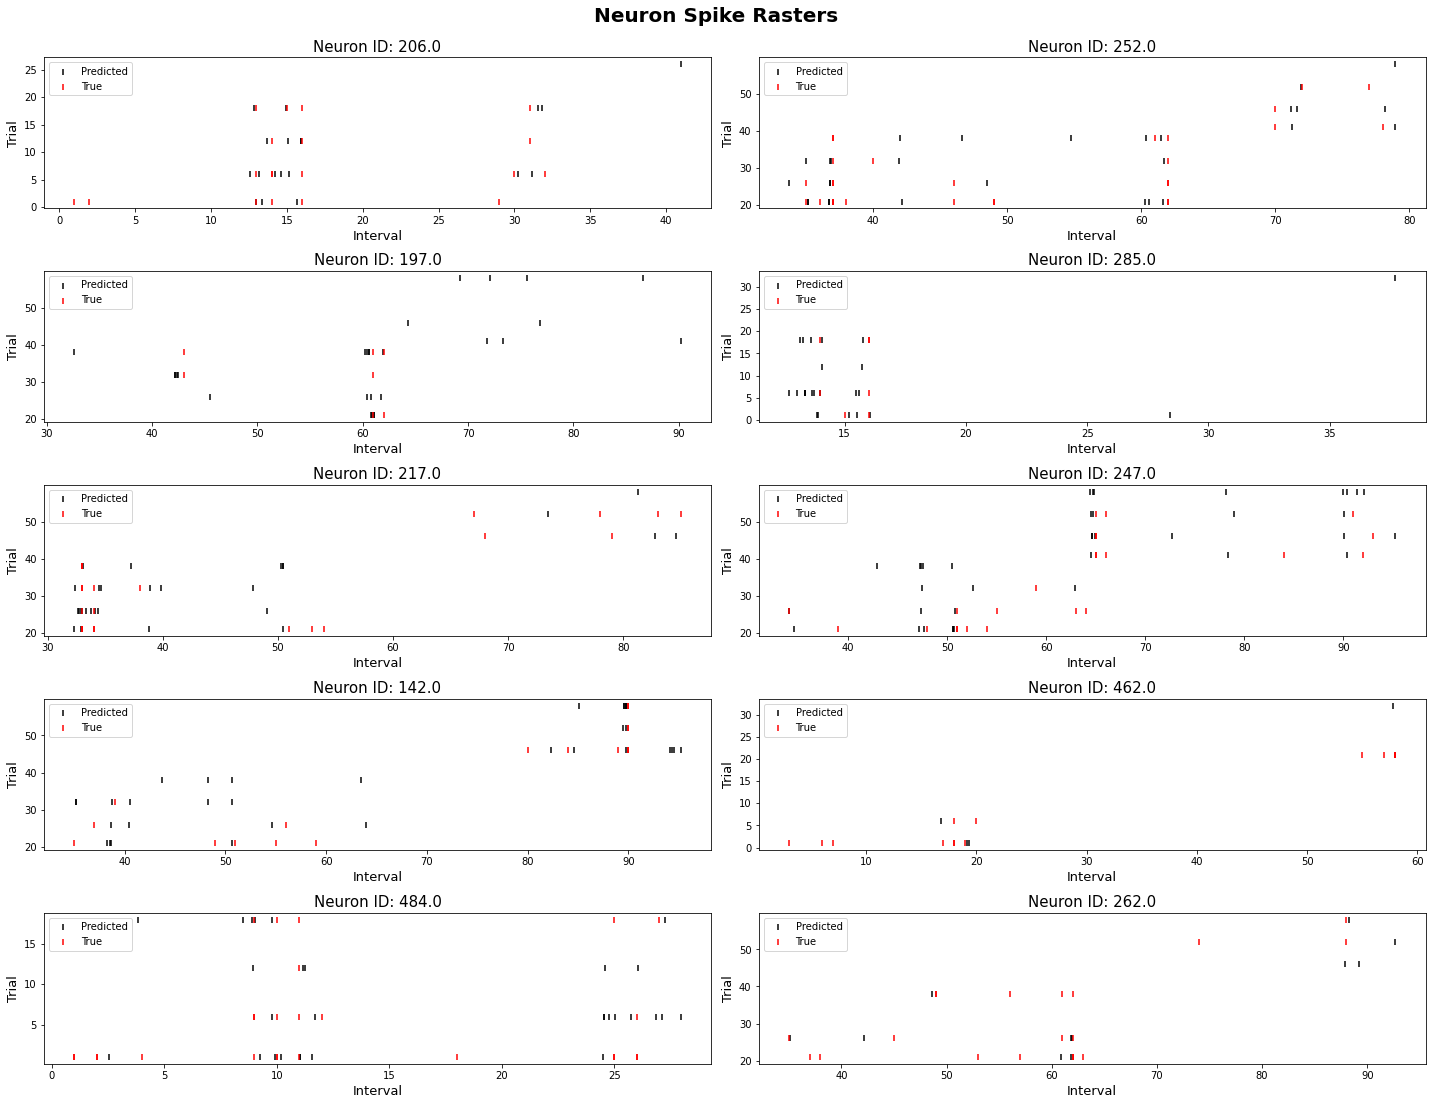

In [77]:
plt.figure(figsize=(20, 15))
for i in range(0, 10):
    neuron_id = top_ids.iloc[i]['ID']
    neuron_pred = df_pred[df_pred['ID'] == neuron_id]
    trials = neuron_pred['Trial'].unique()
    neuron_true = df[(df['ID'] == neuron_id) & (df['Trial'].isin(trials))]
    neuron_pred_times = neuron_pred['Time']
    neuron_true_times = neuron_true['Time']
    neuron_pred = neuron_pred.sort_values(by=['Time'])
    neuron_true = neuron_true.sort_values(by=['Time'])
    plt.subplot(5, 2, i+1)  # Displaying 5 rows, 2 columns of plots.
    plt.scatter(neuron_pred['Interval'], neuron_pred['Trial'], color='k', marker='|', label='Predicted')
    plt.scatter(neuron_true['Interval'], neuron_true['Trial'], color='r', marker='|', label='True')
    plt.title('Neuron ID: ' + str(neuron_id), fontsize=15)
    plt.xlabel('Interval', fontsize=13)
    plt.ylabel('Trial', fontsize=13)
    plt.legend()
plt.tight_layout()  # To ensure the subplots do not overlap
plt.suptitle('Neuron Spike Rasters', fontsize=20, y=1.02)  # Main title for all subplots
plt.show()

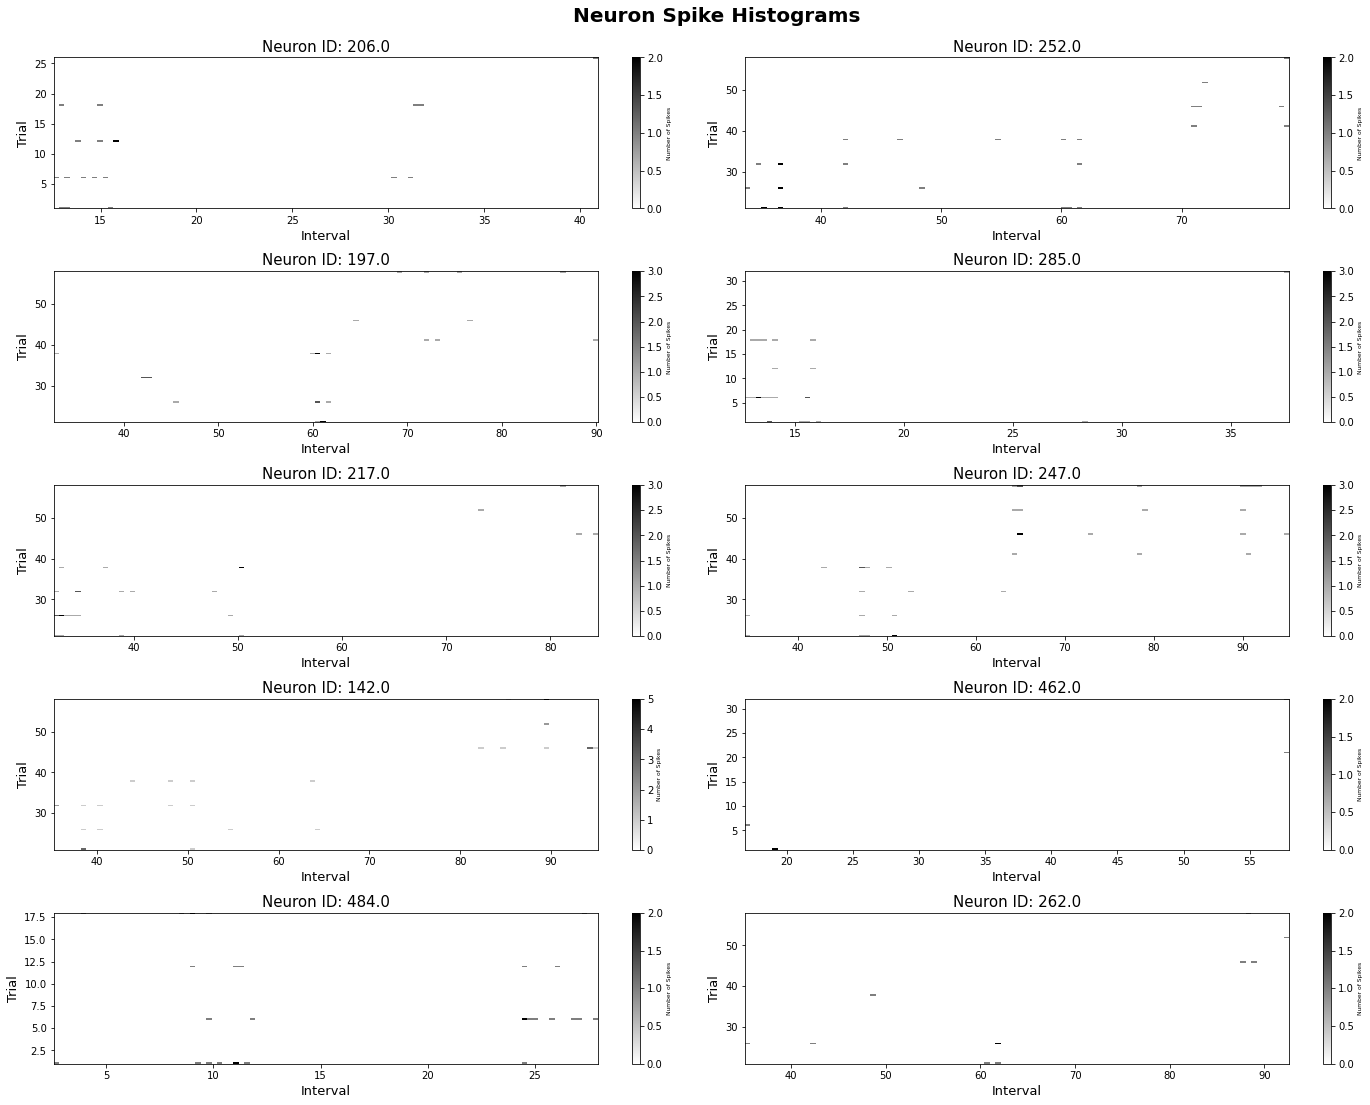

In [71]:
plt.figure(figsize=(20, 15))

for i in range(0, 10):
    neuron_id = top_ids.iloc[i]['ID']
    neuron = df_pred[df_pred['ID'] == neuron_id]
    neuron_times = neuron['Time']
    neuron = neuron.sort_values(by=['Time'])
    plt.subplot(5, 2, i+1)  # Displaying 5 rows, 2 columns of plots.
    
    # Define the number of bins to suit your data
    plt.hist2d(neuron['Interval'], neuron['Trial'], bins=[100, 100], cmap='binary')
    
    plt.title('Neuron ID: ' + str(neuron_id), fontsize=15)
    plt.xlabel('Interval', fontsize=13)
    plt.ylabel('Trial', fontsize=13)
    plt.colorbar(label='Number of Spikes')  # Shows the color scale
    
plt.tight_layout()  # To ensure the subplots do not overlap
plt.suptitle('Neuron Spike Histograms', fontsize=20, y=1.02)  # Main title for all subplots
plt.show()

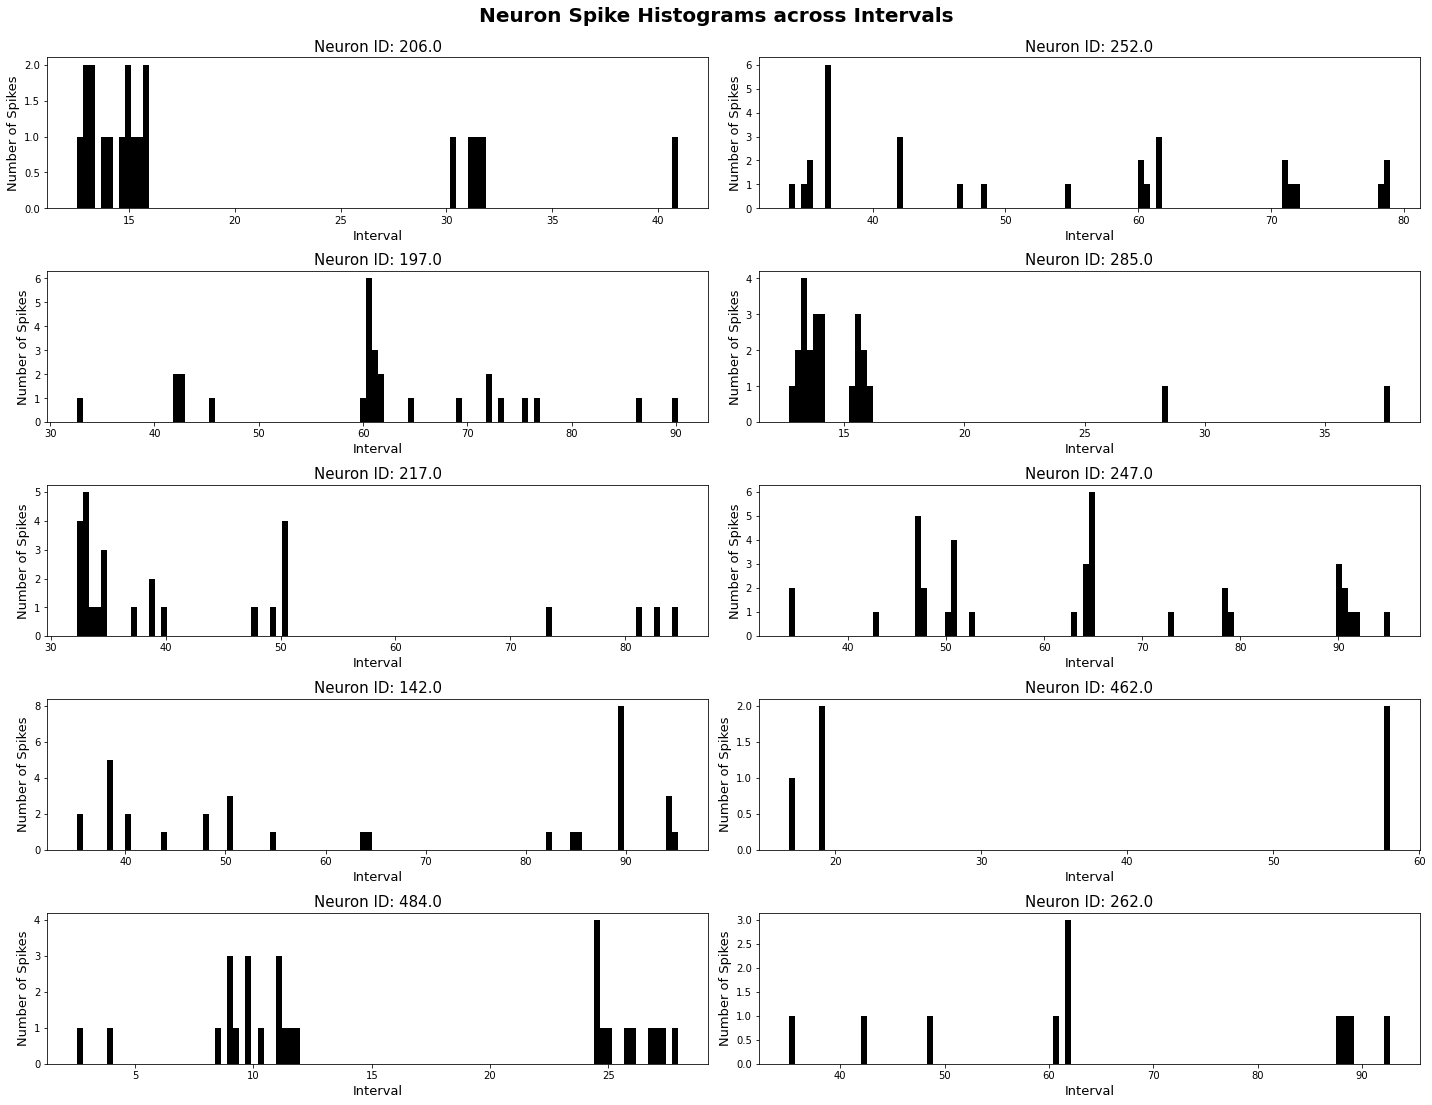

In [72]:
plt.figure(figsize=(20, 15))

for i in range(0, 10):
    neuron_id = top_ids.iloc[i]['ID']
    neuron = df_pred[df_pred['ID'] == neuron_id]
    neuron_times = neuron['Time']
    neuron = neuron.sort_values(by=['Time'])
    plt.subplot(5, 2, i+1)  # Displaying 5 rows, 2 columns of plots.
    
    # Define the number of bins to suit your data
    plt.hist(neuron['Interval'], bins=100, color='black')
    
    plt.title('Neuron ID: ' + str(neuron_id), fontsize=15)
    plt.xlabel('Interval', fontsize=13)
    plt.ylabel('Number of Spikes', fontsize=13)
    
plt.tight_layout()  # To ensure the subplots do not overlap
plt.suptitle('Neuron Spike Histograms across Intervals', fontsize=20, y=1.02)  # Main title for all subplots
plt.show()